In [1]:
import logging
import string
import os
from nltk.corpus import stopwords
import numpy as np
import pickle
import pandas as pd
from pprint import pprint
import re 
from IPython.display import clear_output
import praw

# Gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Suppressing warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# OPTIONAL: logging Gensim output
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
reddit = praw.Reddit(client_id ='BO8N7WITvefntQ',
                     client_secret ='9JVlpSfQz_uGVWetcNN7Dpq1lTM',
                     user_agent ='DIGHUM160 by /u/RichRollin',
                     username ='RichRollin',
                     password ='fairchild')

In [3]:
subreddit = reddit.subreddit("PoliticalHumor")
print(subreddit.title)

Your illicit drug for dealing with 2019 politics


In [4]:
submissions = pd.read_csv("ph-submissions.csv", lineterminator='\n', encoding="utf8")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
comments = pd.read_csv("ph-comments.csv", lineterminator='\n', encoding="utf8")

In [6]:
len(submissions)

321573

In [7]:
len(comments)

4622044

In [8]:
comments = comments[~comments['body'].isin(['[removed]', '[deleted]' ])].dropna(subset=['body'])

In [9]:
dataD = {}
for i, r in comments.iterrows():
    if r.idstr not in dataD.keys():
        dataD[r.idstr] = [ r.body]    
    else:
        dataD[r.idstr].append(r.body)

In [10]:
comments.head()

,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
0,26130445216,t1_c05e4kg,1221159403,[deleted],t3_70xh2,t3_70xh2,That was very funny and also a horrible remind...,1,PoliticalHumor,NaN,111
1,26130583530,t1_c05h3ai,1221701465,live52,t3_71zq4,t3_71zq4,"""This is a shocking invasion of the Governor's...",1,PoliticalHumor,NaN,226
2,26130647319,t1_c05igif,1221948438,HeirToPendragon,t3_72bw6,t3_72bw6,Muppets don't have strings!,1,PoliticalHumor,NaN,27
5,26130680171,t1_c05j5uz,1222101904,live52,t3_72u1p,t3_72u1p,I was prepared for a RickRoll but... Is that a...,1,PoliticalHumor,NaN,60
6,26130813551,t1_c05m0rz,1222562339,[deleted],t3_73yjj,t3_73yjj,lame,1,PoliticalHumor,NaN,4


In [11]:
dataD['t1_c05m0rz']

['lame']

In [12]:
data = ['\n'.join(thread) for thread in dataD.values()]

In [13]:
data

['That was very funny and also a horrible reminder of how far afield the U.S. is after 8 years of these scumbags.',
 '"This is a shocking invasion of the Governor\'s privacy and a violation of law." \n\nIncredible hypocrisy. His connections to bush/rove/cheney/nsa/etc give his staff immediate access to anyone\'s email and telephone communication.',
 "Muppets don't have strings!",
 'I was prepared for a RickRoll but... Is that a real episode?',
 'lame',
 'These stories always leave out the best part; Thomas Jefferson, the author of the Declaration of Independence and third president of the United States, actually professed how evil and cruel the Abrahamic (including Christianity...) religions were.',
 'If only someone could snap a pic of her signing a big zero over her head.',
 "The sad thing is, I could print this stuff out and show it to my fundie coworkers, and not only would they most likely believe that these were actual quotes; they'd defend them.",
 "That was FREAKING AWESOME.  A

In [14]:
# Remove newline characters
data = [re.sub('\s+', ' ', txt) for txt in data]

# Remove single quotes
data = [re.sub("\'", "", txt) for txt in data]

In [15]:
def tokenizer(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))  # deacc=True removes punctuations
tokens = list(tokenizer(data))

In [16]:
len(tokens)

4393250

In [17]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100) # higher threshold = fewer phrases.
trigram = gensim.models.Phrases(bigram[tokens], threshold=100)  

# `Phraser` must be built from an initial `Phrases` instance. 
# It then works a little faster while using much less memory. See https://radimrehurek.com/gensim/models/phrases.html
bigramMod = gensim.models.phrases.Phraser(bigram)
trigramMod = gensim.models.phrases.Phraser(trigram)

In [18]:
print(trigramMod[bigramMod[tokens[0]]])

['that', 'was', 'very', 'funny', 'and', 'also', 'horrible', 'reminder', 'of', 'how', 'far', 'afield', 'the', 'is', 'after', 'years', 'of', 'these', 'scumbags']


In [19]:
# prepare stopwords
stop = set(stopwords.words('english') + ['’', '“', '”', 'nbsp', 'http'])

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in doc if word not in stop] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [21]:

#%%time

# Remove stopwords
tokensNoStops = removeStopwords(tokens)

# Form trigrams
trigrams = makeTrigrams(tokensNoStops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization 
lemmas = lemmatization(trigrams)

In [22]:
# Create Dictionary 
dictionary = corpora.Dictionary(lemmas)

# Create Corpus, i.e. Document-Term Matrix
corpus = [dictionary.doc2bow(text) for text in lemmas]

In [56]:
print(corpus[0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [57]:
dictionary[5]

'reminder'

In [58]:
with open("corp.cor", "wb") as fp: 
    pickle.dump(corpus, fp)

In [ ]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
ldaModel.save("ldaModel-PoliticalHumor")

In [ ]:
ldaModel = ldaModel.load("ldaModel-PoliticalHumor")

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
panel

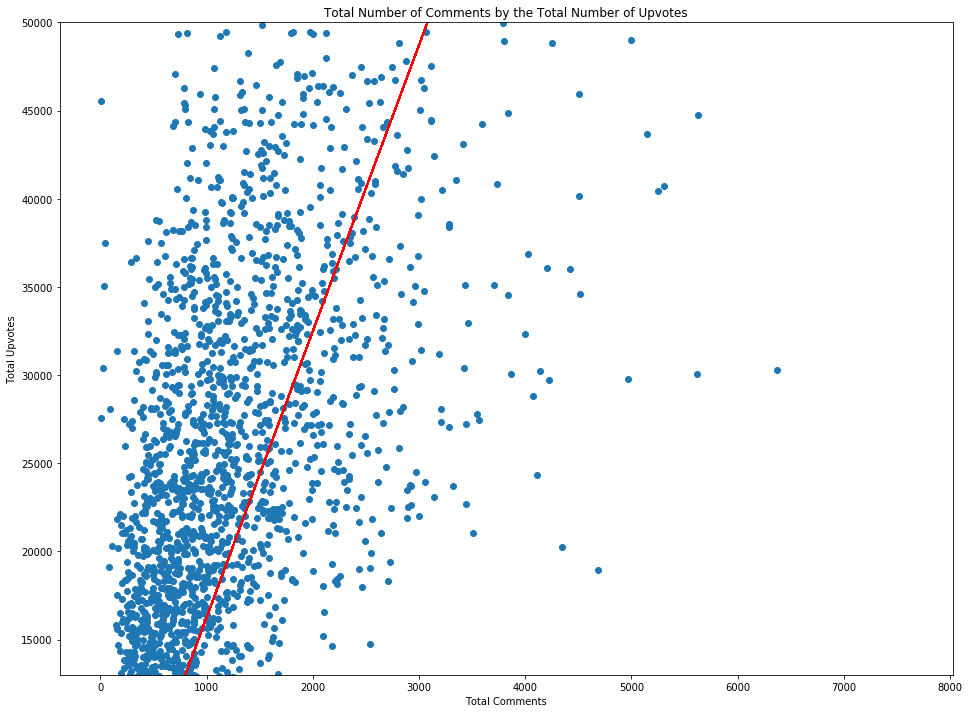

In [25]:
# Scatter Plot
plt.figure(figsize=(16,12))
plt.scatter(submissions['num_comments'], submissions['score'])
plt.title("Total Number of Comments by the Total Number of Upvotes")
plt.ylabel("Total Upvotes")
plt.xlabel("Total Comments")
plt.ylim(13000, 50000)
x = submissions["num_comments"]
y = submissions["score"]

# Regression Line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

# Pretty Output
plt.show()

In [40]:
submissions['num_comments/upvotes'] = submissions['num_comments'] / submissions['score']

In [41]:
submissions

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,subreddit,distinguish,textlen,num_comments,flair_text,flair_css_class,augmented_at,augmented_count,num_comments/upvotes
0,11751099,t3_6zv7f,1220634325,0,0,EllieElliott,Northern Non-Exposure or Things To Do in Junea...,http://www.reddit.com/submit?url=http%3A%2F%2F...,NaN,2,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
1,11751185,t3_6zv9t,1220634997,0,0,EllieElliott,Steve Sack: The Bush Years,http://cartoonbox.slate.com/stevesack/2008/09/04/,NaN,2,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
2,11751328,t3_6zvds,1220635999,0,0,EllieElliott,Reading The Pictures: RNC Final Night Top 10,http://www.huffingtonpost.com/michael-shaw/rea...,NaN,1,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
3,11751404,t3_6zvfw,1220636501,0,0,EllieElliott,Hmm. Maybe not the best idea for the candidate...,http://www.dependablerenegade.com/dependable_r...,NaN,2,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
4,11753574,t3_6zx46,1220652726,0,0,EllieElliott,Tony Auth: McCain v Washington,http://news.yahoo.com/comics/uclickcomics/2008...,NaN,1,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
5,11753578,t3_6zx4a,1220652782,0,0,EllieElliott,McCain: I'm Different,http://editorialcartoonists.com/cartoon/displa...,NaN,2,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
6,11753758,t3_6zx9a,1220654790,0,0,EllieElliott,"Lies, Lies, Lies… Yeah",http://sleepingdonkey.wordpress.com/2008/09/05...,NaN,1,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
7,11759088,t3_701dc,1220728374,0,0,EllieElliott,Another 100 hours in Palin-land,http://www.orlandoweekly.com/blog/default.asp?...,NaN,1,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000
8,11773745,t3_70coh,1220908337,0,0,EllieElliott,Michael Palin for President,http://www.youtube.com/watch?v=jf1y9s73Nos,NaN,0,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,NaN
9,11778269,t3_70g65,1220959790,0,0,twolf1,Predicted Charley Gibson Questions for Palin,http://firedoglake.com/2008/09/09/predicted-ch...,NaN,1,PoliticalHumor,NaN,0,0,NaN,NaN,NaN,NaN,0.000000


In [46]:
indexNames = submissions[ submissions['num_comments/upvotes'] == 0 ].index
 
submissions.drop(indexNames , inplace=True)

In [51]:
submissions_clean = submissions.dropna(axis=1, how='all')

In [55]:
submissions_clean.sort_values(['score'], ascending = False).head(50)

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,subreddit,distinguish,textlen,num_comments,flair_text,num_comments/upvotes
193151,544227861,t3_900owl,1531957619,0,0,GucciGameboy,Russian Pipeline. Upvote so that this is the f...,https://i.redd.it/8g04gvo0nsa11.jpg,NaN,102420,PoliticalHumor,NaN,0,1846,NaN,0.018024
193732,544722723,t3_90baqr,1532046409,0,0,That__0n3__guy,Vladimir Putin’s wife. Upvote so this is the f...,https://i.redd.it/dx5rree1zza11.jpg,NaN,79375,PoliticalHumor,NaN,0,1127,All posts must contain some kind of humor,0.014198
270786,662980599,t3_aypz3r,1552049804,0,0,matteoms,Laundry Room Treason,https://i.redd.it/x5mb6l9a7wk21.jpg,NaN,72076,PoliticalHumor,NaN,0,2090,r/All,0.028997
269924,661325294,t3_axqhv2,1551821408,0,0,Gawd_of_oh_Lawd,His lies require advanced tracking,https://i.redd.it/nphkk1h9cdk21.jpg,NaN,71161,PoliticalHumor,NaN,0,1183,NaN,0.016624
251110,634499441,t3_ahriwh,1547939673,0,0,GallowBoob,Racist kids yelling at Native Americans Vetera...,https://i.redd.it/d999pf3vpgb21.jpg,NaN,70793,PoliticalHumor,NaN,0,3014,NaN,0.042575
244492,626253346,t3_acus6a,1546700268,0,0,dippindotssuck,Not obsessed.,https://i.redd.it/c1vl8mhhcm821.jpg,NaN,70058,PoliticalHumor,NaN,0,4692,NaN,0.066973
253616,637487029,t3_ajjk51,1548378079,0,0,BurayanFury,How the Trump investigations feel like,https://i.imgur.com/XDgHj8r.gifv,NaN,69898,PoliticalHumor,NaN,0,1608,*What the investigations feel like,0.023005
259393,644812523,t3_anwkiz,1549492607,0,0,Tannrr,I’ll just put this here.,https://i.redd.it/d3djh4ajz0f21.jpg,NaN,69894,PoliticalHumor,NaN,0,2189,NaN,0.031319
258134,643145543,t3_amwu9z,1549245944,0,0,IDontGetIt404,Super Bowl joKe,https://i.redd.it/4700k933mge21.jpg,NaN,68638,PoliticalHumor,NaN,0,809,NaN,0.011786
246621,629285603,t3_aenrvn,1547155991,0,0,aabbccbb,A plan for the wall.,https://i.imgur.com/MJnGrpJ.jpg,NaN,67126,PoliticalHumor,NaN,0,1899,NaN,0.028290
